In [1]:
import glob
import json
import os
import pickle
import re
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from misc.utils import ProgressPrinter, cached, parse_as

%load_ext pyinstrument
%matplotlib inline

In [43]:
##################################################
# User Settings
##################################################
# Change these to influence the execution of the
# notebook.
# You can override these from the command line
# by defining environment variables with the
# name of the constants below, prefixed with
# "ANA_NB_".
# For example, the environment variable
# "ANA_NB_TR_PATH" will override the "TR_PATH"
# setting below.
##################################################

# The path to the build folder of a ROS2 workspace that contains the
# tracetools_read and tracetools_analysis folders.
TRACING_WS_BUILD_PATH = "../src/build"

# Path to trace directory (e.g. ~/.ros/my-trace/ust) or to a converted trace file.
# Using the path "/ust" at the end is optional but greatly reduces processing time
# if kernel traces are also present.
TR_PATH = "../sa-tracing-results/140922/01/ust"

# Path to the folder all artifacts from this notebook are saved to.
# This entails plots as well as data tables.
OUT_PATH = "out/"

# Whether to annotate topics/publications with bandwidth/message size
BW_ENABLED = False
# Path to a results folder as output by ma-hw-perf-tools/messages/record.bash
# Used to annotate message sizes in E2E latency calculations
BW_PATH = "../ma-hw-perf-tools/data/results"

# Whether to use dependencies extracted by the Clang-tools to supplement
# automatic node-internal data flow annotations.
# If in doubt, set to False.
CL_ENABLED = False
# Path to the output directory of the ROS2 dependency checker.
# Will only be used if CL_ENABLED is True.
CL_PATH = "~/Projects/llvm-project/clang-tools-extra/ros2-internal-dependency-checker/output"

# Whether to compute data flow graphs.
# If you are only interested in E2E latencies, set this to False
DFG_ENABLED = False
# Whether to plot data flow graphs (ignored if DFG_ENABLED is False)
DFG_PLOT = False

# The maximum node namespace hierarchy level to be plotted.
# Top-level (1): e.g. /sensing, /control, etc.
# Level 3: e.g. /sensing/lidar/pointcloud_processor
DFG_MAX_HIER_LEVEL = 100

# RegEx pattern for nodes that shall be marked as system inputs
# These will be plotted with a start arrow as known from automata diagrams
DFG_INPUT_NODE_PATTERNS = [r"^/sensing"]
# RegEx pattern for nodes that shall be marked as system outputs
# These will be plotted with a double border
DFG_OUTPUT_NODE_PATTERNS = [r"^/awapi", r"^/control/external_cmd_converter"]
# RegEx for nodes which shall not be plotted in the DFG
DFG_EXCL_NODE_PATTERNS = [r"^/rviz2", r"transform_listener_impl"]

# Whether to compute E2E latencies.
E2E_ENABLED = True
# Whether to plot end-to-end latency information (ignored if E2E_ENABLED is False)
E2E_PLOT = False
# The index of the output message that shall be used in plots that visualize a specific
# message dependency tree. This index has to be 0 <= n < #output messages
E2E_PLOT_TIMESTAMP = 200
# E2E latency threshold. Every E2E latency higher than this is discarded.
# Set this as low as comfortably possible to speed up calculations.
# WARNING: If you set this too low (i.e. to E2E latencies that plausibly can happen)
# your results will be wrong)
E2E_TIME_LIMIT_S = 2

# All topics containing any of these RegEx patterns are considered output topics in E2E latency calculations
# E.g. r"^/control/" will cover all control topics
E2E_OUTPUT_TOPIC_PATTERNS = [r"^/control/command/control_cmd"]
#E2E_OUTPUT_TOPIC_PATTERNS = [r"^/system/emergency/control_cmd"]
# All topics containing any of these RegEx patterns are considered input topics in E2E latency calculations
# E.g. r"^/sensing/" will cover all sensing topics
E2E_INPUT_TOPIC_PATTERNS = ["/vehicle/status/", "/perception/"]
#E2E_INPUT_TOPIC_PATTERNS = ["/vehicle/", "/sensing/", "/localization/", "planning"]


# This code overrides the above constants with environment variables, do not edit.
for env_key, env_value in os.environ.items():
    if env_key.startswith("ANA_NB_"):
        key = env_key.removeprefix("ANA_NB_")
        if key not in globals().keys():
            continue
        value = parse_as(type(globals()[key]), env_value)
        globals()[key] = value

# Convert input paths to absolute paths
def _expand_path(path):
    return os.path.realpath(os.path.expandvars(os.path.expanduser(path)))

TRACING_WS_BUILD_PATH = _expand_path(TRACING_WS_BUILD_PATH)
TR_PATH = _expand_path(TR_PATH)
OUT_PATH = _expand_path(OUT_PATH)
BW_PATH = _expand_path(BW_PATH)
CL_PATH = _expand_path(CL_PATH)

os.makedirs(OUT_PATH, exist_ok=True)

In [3]:
from clang_interop.cl_types import ClContext
from clang_interop.process_clang_output import process_clang_output

sys.path.append(os.path.join(TRACING_WS_BUILD_PATH, "tracetools_read/"))
sys.path.append(os.path.join(TRACING_WS_BUILD_PATH, "tracetools_analysis/"))
from tracetools_read.trace import *
from tracetools_analysis.loading import load_file
from tracetools_analysis.processor.ros2 import Ros2Handler
from tracetools_analysis.utils.ros2 import Ros2DataModelUtil

from tracing_interop.tr_types import TrTimer, TrTopic, TrPublisher, TrPublishInstance, TrCallbackInstance, \
TrCallbackSymbol, TrCallbackObject, TrSubscriptionObject, TrContext

# Organize Trace Data

In [4]:
def _load_traces():
    file = load_file(TR_PATH)
    handler = Ros2Handler.process(file)
    return TrContext(handler)


_tracing_context = cached("tr_objects", _load_traces, [TR_PATH])
_tr_globals = ["nodes", "publishers", "subscriptions", "timers", "timer_node_links", "subscription_objects",
               "callback_objects", "callback_symbols", "publish_instances", "callback_instances", "topics"]

# Help the IDE recognize those identifiers
nodes = publishers = subscriptions = timers = timer_node_links = subscription_objects = callback_objects = callback_symbols = publish_instances = callback_instances = topics = None

for name in _tr_globals:
    globals()[name] = getattr(_tracing_context, name)

print("Done.")

[CACHE] Found up-to-date cache entry (cache/tr_objects_507fec94db.pkl) for tr_objects, loading.
Done.


In [42]:
for t in topics:
    if "control" in t.name:
        print(t.name)

/control/external_cmd_selector/current_selector_mode
/system/emergency/control_cmd
/control/command/hazard_lights_cmd
/control/command/turn_indicators_cmd
/api/external/set/command/local/control
/control/trajectory_follower/lane_departure_checker_node/debug/deviation/yaw
/control/command/control_cmd
/api/iv_msgs/vehicle/status/control_mode
/control/trajectory_follower/control_cmd
/api/external/set/command/remote/control
/control/trajectory_follower/lateral/diagnostic
/control/trajectory_follower/lane_departure_checker_node/debug/deviation/yaw_deg
/control/trajectory_follower/lane_departure_checker_node/debug/deviation/lateral
/control/vehicle_cmd_gate/operation_mode
/control/trajectory_follower/longitudinal/slope_angle
/vehicle/status/control_mode
/external/selected/external_control_cmd
/control/is_autonomous_available
/control/trajectory_follower/lane_departure_checker_node/debug/processing_time_ms
/control/operation_mode
/control/trajectory_follower/lane_departure_checker_node/debug/

# E2E Latency Calculation

In [5]:
from latency_graph import latency_graph as lg

def _make_latency_graph():
    return lg.LatencyGraph(_tracing_context)

lat_graph = cached("lat_graph", _make_latency_graph, [TR_PATH])

[CACHE] Found up-to-date cache entry (cache/lat_graph_507fec94db.pkl) for lat_graph, loading.


  Processing INPUT: 1
  Processing OUTPUT: 1
  Processing simulation: 0
    Processing openscenario_visualizer: 2
    Processing simple_sensor_simulator: 1
    Processing openscenario_interpreter: 19
    Processing concealer: 22
  Processing system: 0
    Processing system_monitor: 0
      Processing system_monitor: 0
        Processing system_monitor_container: 1
      Processing cpu_monitor: 2
      Processing hdd_monitor: 3
      Processing mem_monitor: 2
      Processing net_monitor: 2
      Processing ntp_monitor: 2
      Processing process_monitor: 3
      Processing gpu_monitor: 2
    Processing emergency_handler: 7
    Processing system_error_monitor: 6
    Processing ad_service_state_monitor: 9
    Processing transform_listener_impl_5640698e3b70: 3
  Processing map: 0
    Processing map_container: 1
    Processing lanelet2_map_loader: 1
    Processing lanelet2_map_visualization: 2
    Processing pointcloud_map_loader: 1
    Processing vector_map_tf_generator: 2
  Processing pl

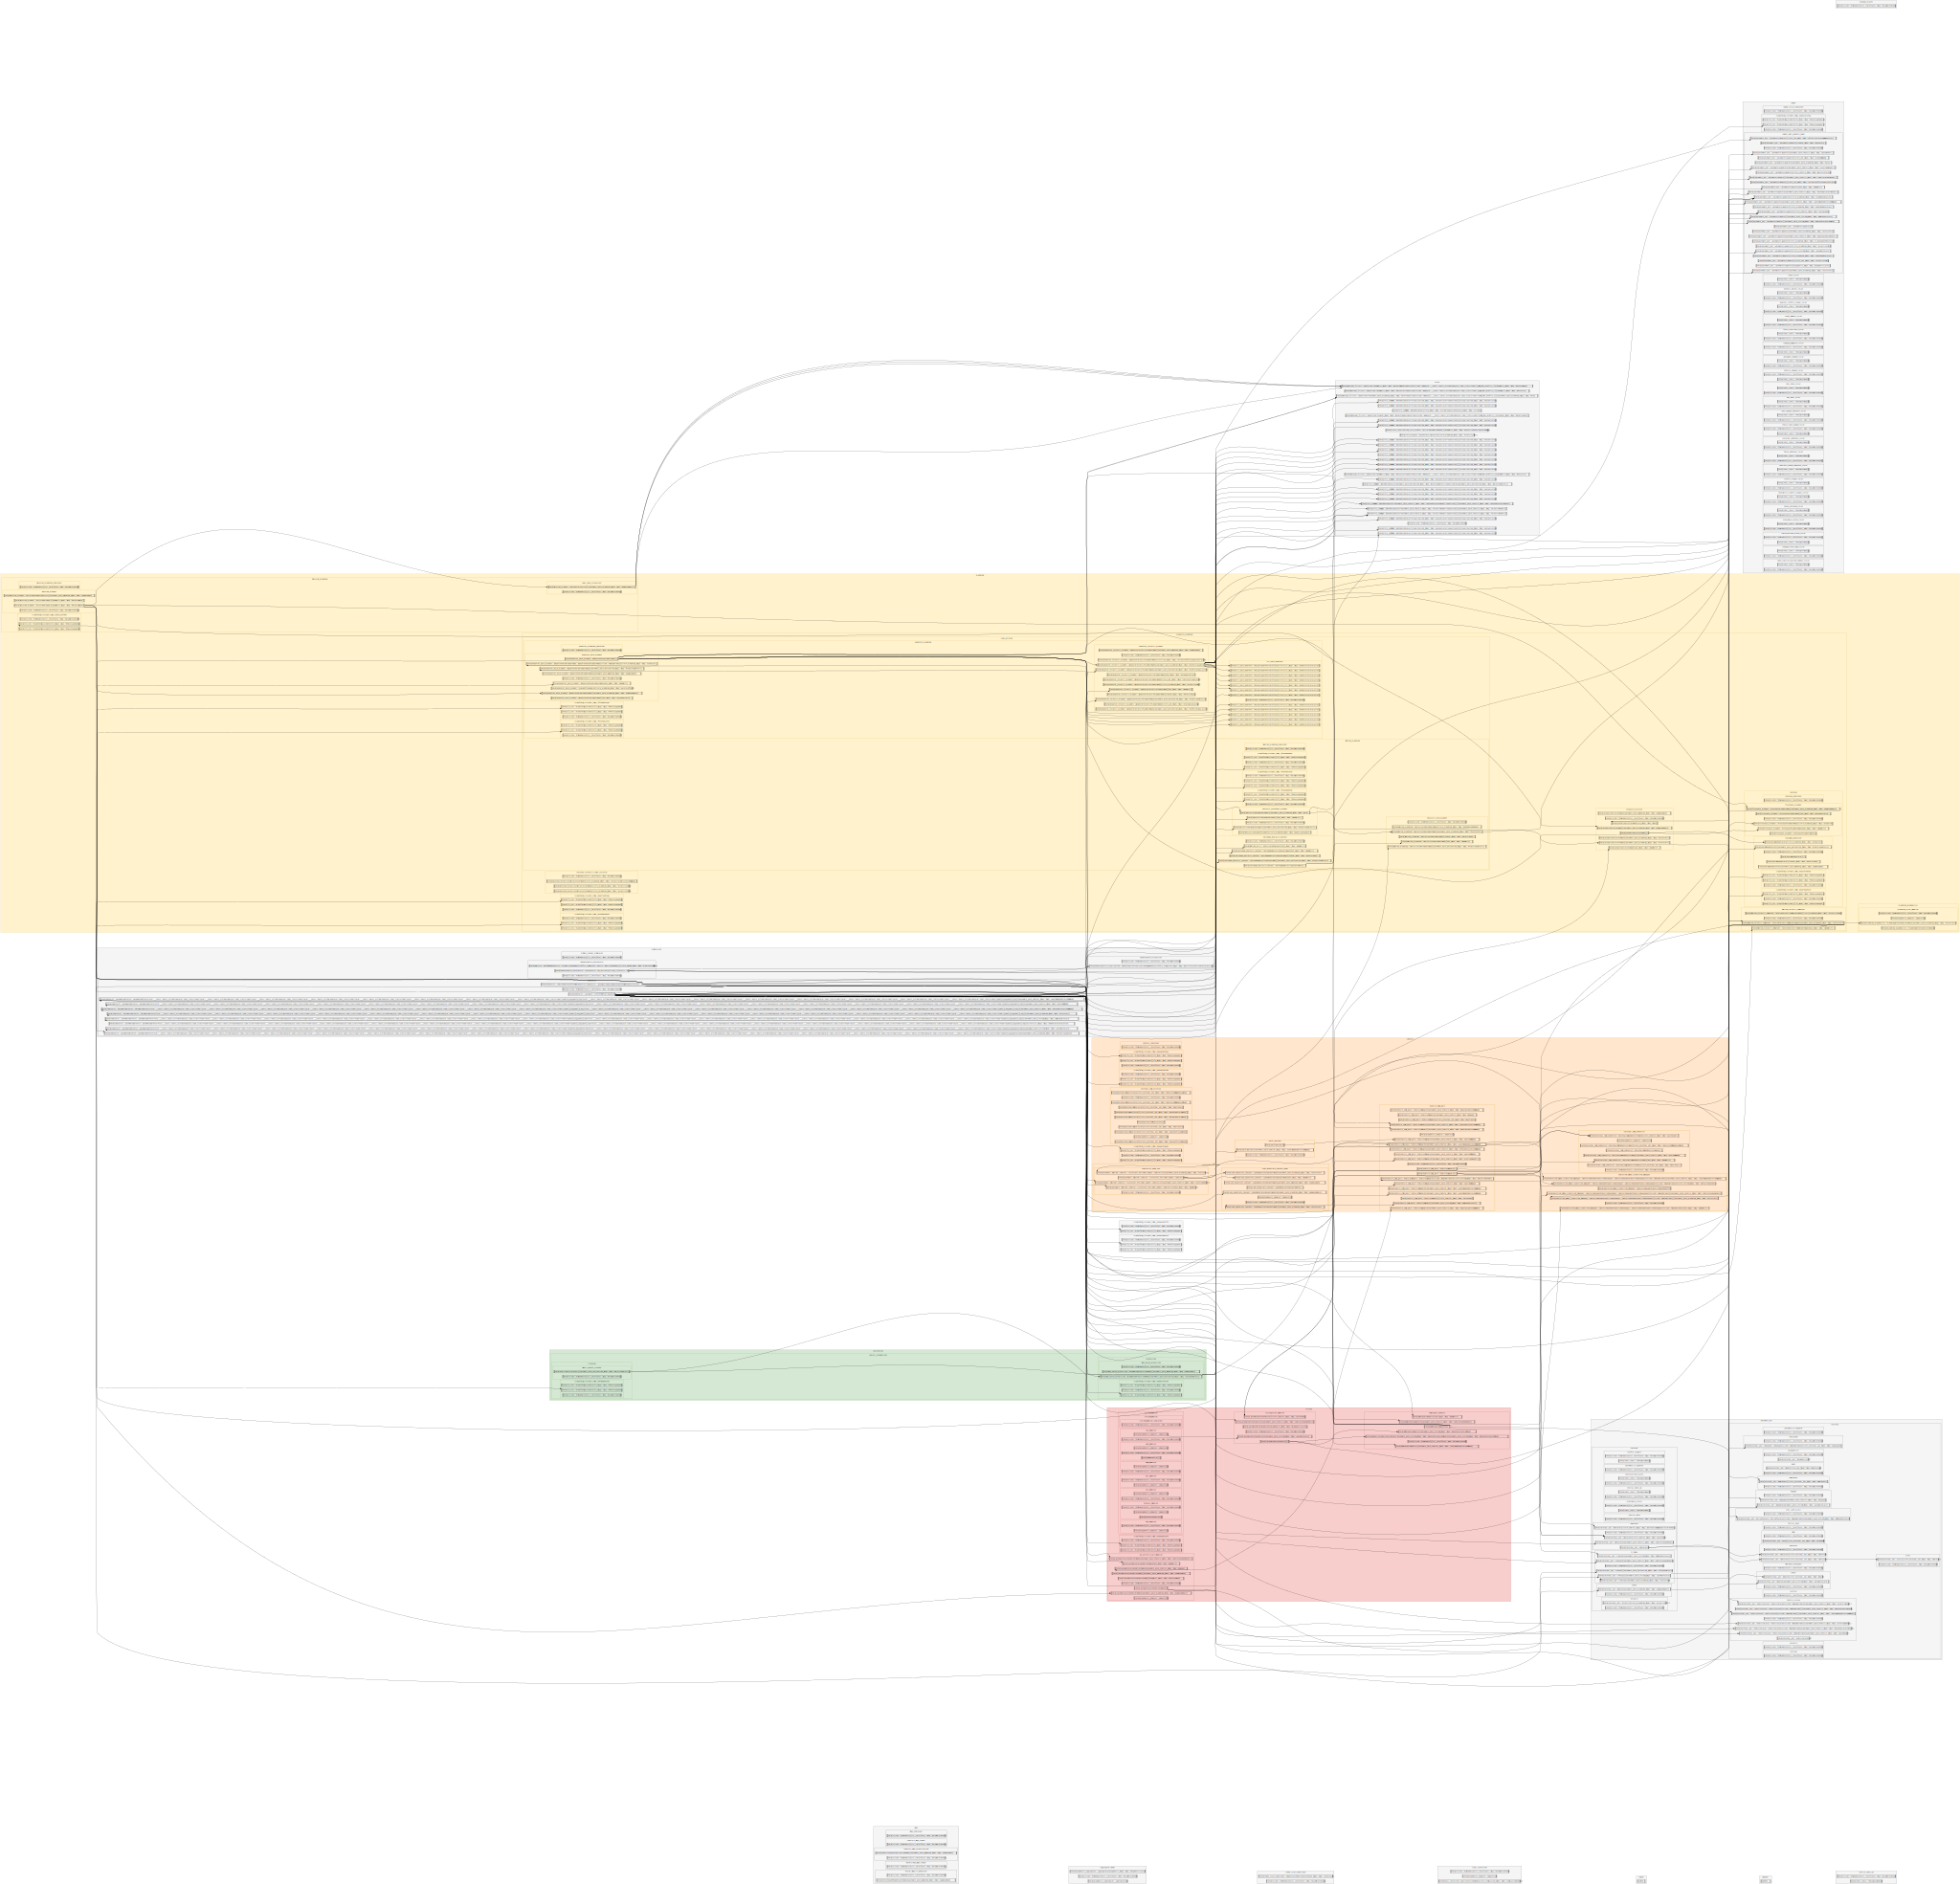

In [6]:
%%skip_if_false DFG_ENABLED
%%skip_if_false DFG_PLOT

from matching.subscriptions import sanitize
from typing import Iterable, Sized
from tracing_interop.tr_types import TrNode, TrCallbackObject, TrCallbackSymbol, TrSubscriptionObject

#################################################
# Plot DFG
#################################################

# Compare with: https://autowarefoundation.github.io/autoware-documentation/main/design/autoware-architecture/node-diagram/
node_colors = {
        "sensing": {"fill": "#e1d5e7", "stroke": "#9673a6"},
        "localization": {"fill": "#dae8fc", "stroke": "#6c8ebf"},
        "perception": {"fill": "#d5e8d4", "stroke": "#82b366"},
        "planning": {"fill": "#fff2cc", "stroke": "#d6b656"},
        "control": {"fill": "#ffe6cc", "stroke": "#d79b00"},
        "system": {"fill": "#f8cecc", "stroke": "#b85450"},
        "vehicle_interface": {"fill": "#b0e3e6", "stroke": "#0e8088"},
        None: {"fill": "#f5f5f5", "stroke": "#666666"}
}

node_namespace_mapping = {
        'perception': 'perception',
        'sensing': 'sensing',
        'planning': 'planning',
        'control': 'control',
        'awapi': None,
        'autoware_api': None,
        'map': None,
        'system': 'system',
        'localization': 'localization',
        'robot_state_publisher': None,
        'aggregator_node': None,
        'pointcloud_container': 'sensing',
}

import graphviz as gv

g = gv.Digraph('G', filename="latency_graph.gv",
               node_attr={'shape': 'plain'},
               graph_attr={'pack': '1'})
g.graph_attr['rankdir'] = 'LR'

def plot_hierarchy(gv_parent, lg_node: lg.LGHierarchyLevel, **subgraph_kwargs):
    if lg_node.name == "[NONE]":
        return

    print(f"{'  ' * lg_node.full_name.count('/')}Processing {lg_node.name}: {len(lg_node.callbacks)}")
    with gv_parent.subgraph(name=f"cluster_{lg_node.full_name.replace('/', '__')}", **subgraph_kwargs) as c:
        c.attr(label=lg_node.name)
        for cb in lg_node.callbacks:
            if isinstance(cb, lg.LGTrCallback):
                tr_cb = cb.cb
                try:
                    sym = _tracing_context.callback_symbols.by_id.get(tr_cb.callback_object)
                    pretty_sym = repr(sanitize(sym.symbol))
                except KeyError:
                    pretty_sym = cb.name
                except TypeError:
                    pretty_sym = cb.name
            else:
                pretty_sym = cb.name

            pretty_sym = pretty_sym.replace("&", "&amp;").replace("<", "&lt;").replace(">", "&gt;")

            c.node(cb.id(),
                   f'<<table BORDER="0" CELLBORDER="1" CELLSPACING="0"><tr><td port="in"></td><td>{pretty_sym}</td><td port="out"></td></tr></table>>')

        for ch in lg_node.children:
            plot_hierarchy(c, ch, **subgraph_kwargs)

def plot_lg(graph: lg.LatencyGraph):
    for top_level_node in graph.top_node.children:
        colors = node_colors[node_namespace_mapping.get(top_level_node.name)]
        plot_hierarchy(g, top_level_node, graph_attr={'bgcolor': colors["fill"], 'pencolor': colors["stroke"]})

    for edge in graph.edges:
        g.edge(f"{edge.start.id()}:out", f"{edge.end.id()}:in")

plot_lg(lat_graph)

g.save("latency_graph.gv")
g.render("latency_graph.svg")

g


/control/external_cmd_converter, /awapi/awapi_relay_container, /awapi/awapi_awiv_adapter_node, /awapi/route_relay, /awapi/predict_object_relay, /awapi/nearest_traffic_signal_relay, /awapi/ready_module_relay, /awapi/force_available_relay, /awapi/running_modules_relay, /awapi/autoware_engage_relay, /awapi/vehicle_engage_relay, /awapi/put_route_relay, /awapi/put_goal_relay, /awapi/lane_change_approval_relay, /awapi/force_lane_change_relay, /awapi/external_approval_relay, /awapi/force_approval_relay, /awapi/obstacle_avoid_approval_relay, /awapi/traffic_signal_relay, /awapi/overwrite_traffic_signals_relay, /awapi/speed_exceeded_relay, /awapi/crosswalk_status_relay, /awapi/intersection_status_relay, /awapi/expand_stop_range_relay, /awapi/pose_initialization_request_relay
/INPUT, /OUTPUT, /[NONE], /simulation/openscenario_visualizer, /simulation/simple_sensor_simulator, /simulation/openscenario_interpreter, /simulation/concealer, /system/system_monitor/system_monitor/system_monitor_container

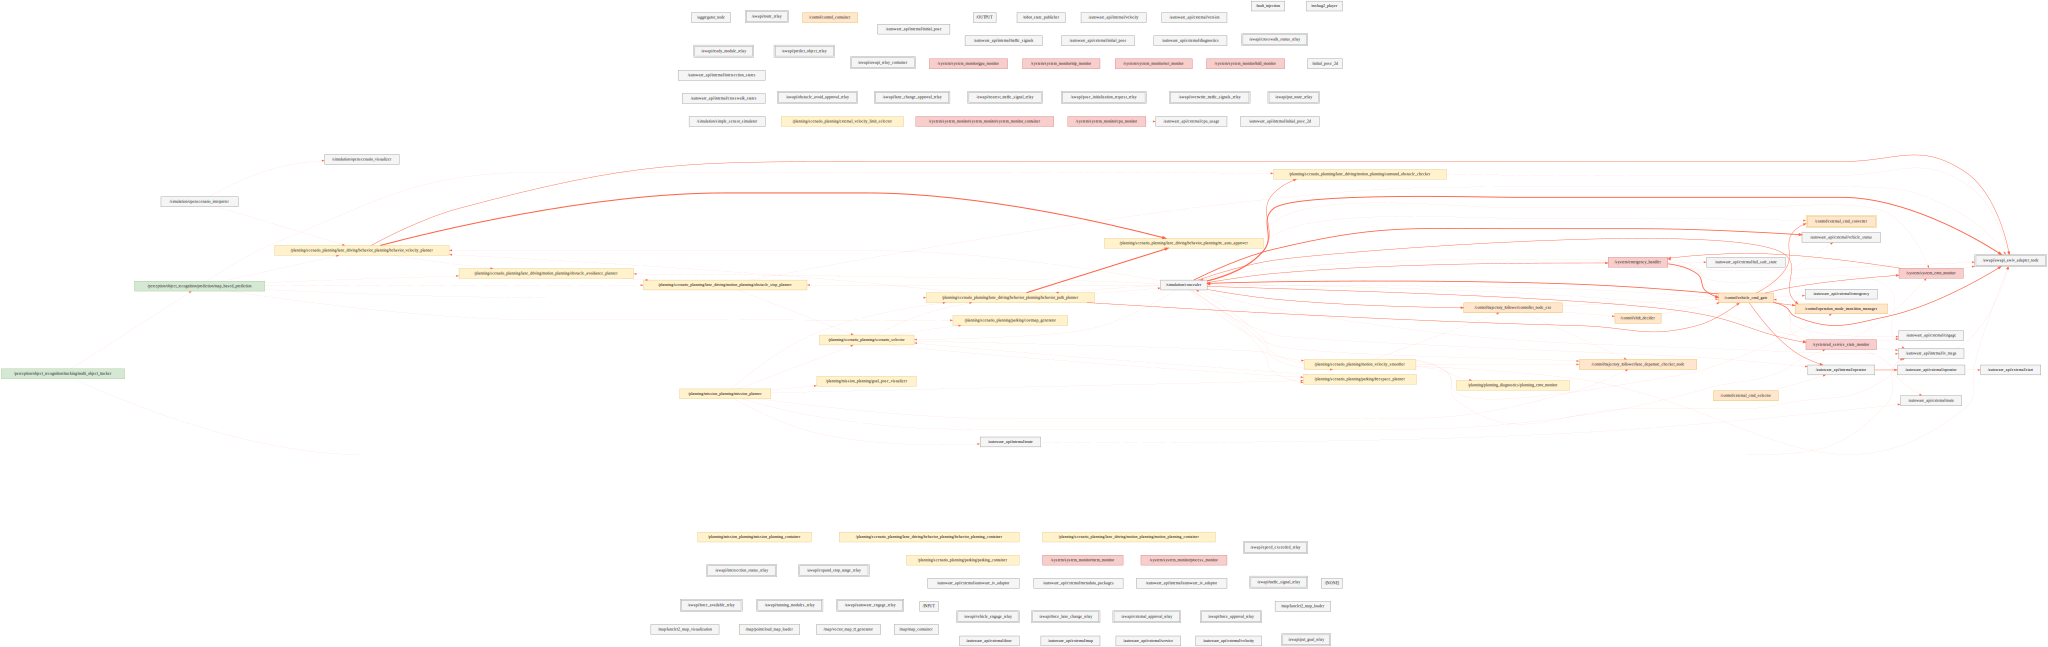

In [7]:
%%skip_if_false DFG_ENABLED
%%skip_if_false DFG_PLOT

import re
import math

##################################################
# Compute in/out topics for hierarchy level X
##################################################

def get_nodes_on_level(lat_graph: lg.LatencyGraph):
    def _traverse_node(node: lg.LGHierarchyLevel, cur_lvl=0):
        if cur_lvl == DFG_MAX_HIER_LEVEL:
            return [node]

        if not node.children and cur_lvl < DFG_MAX_HIER_LEVEL:
            return [node]

        collected_nodes = []
        for ch in node.children:
            collected_nodes += _traverse_node(ch, cur_lvl + 1)
        return collected_nodes

    return _traverse_node(lat_graph.top_node)

lvl_nodes = get_nodes_on_level(lat_graph)
lvl_nodes = [n for n in lvl_nodes if not any(re.search(p, n.full_name) for p in DFG_EXCL_NODE_PATTERNS)]

input_nodes = [n.full_name for n in lvl_nodes if any(re.search(p, n.full_name) for p in DFG_INPUT_NODE_PATTERNS)]
output_nodes = [n.full_name for n in lvl_nodes if any(re.search(p, n.full_name) for p in DFG_OUTPUT_NODE_PATTERNS)]

print(', '.join(map(lambda n: n, input_nodes)))
print(', '.join(map(lambda n: n, output_nodes)))
print(', '.join(map(lambda n: n.full_name, lvl_nodes)))

def _collect_callbacks(n: lg.LGHierarchyLevel):
    callbacks = []
    callbacks += n.callbacks
    for ch in n.children:
        callbacks += _collect_callbacks(ch)
    return callbacks


cb_to_node_map = {}
for n in lvl_nodes:
    cbs = _collect_callbacks(n)
    for cb in cbs:
        cb_to_node_map[cb.id()] = n


edges_between_nodes = {}
for edge in lat_graph.edges:
    from_node = cb_to_node_map.get(edge.start.id())
    to_node = cb_to_node_map.get(edge.end.id())

    if from_node is None or to_node is None:
        continue

    if from_node.full_name == to_node.full_name:
        continue

    k = (from_node.full_name, to_node.full_name)

    if k not in edges_between_nodes:
        edges_between_nodes[k] = []

    edges_between_nodes[k].append(edge)

g = gv.Digraph('G', filename="latency_graph.gv",
               node_attr={'shape': 'plain'},
               graph_attr={'pack': '1'})
g.graph_attr['rankdir'] = 'LR'

for n in lvl_nodes:
    colors = node_colors[node_namespace_mapping.get(n.full_name.strip("/").split("/")[0])]
    peripheries = "1" if n.full_name not in output_nodes else "2"
    g.node(n.full_name, label=n.full_name, fillcolor=colors["fill"], color=colors["stroke"],
           shape="box", style="filled", peripheries=peripheries)

    if n.full_name in input_nodes:
        helper_node_name = f"{n.full_name}__before"
        g.node(helper_node_name, label="", shape="none", height="0", width="0")
        g.edge(helper_node_name, n.full_name)

def compute_e2e_paths(start_nodes, end_nodes, edges):
    frontier_paths = [[n] for n in start_nodes]
    final_paths = []

    while frontier_paths:
        frontier_paths_new = []

        for path in frontier_paths:
            head = path[-1]
            if head in end_nodes:
                final_paths.append(path)
                continue

            out_nodes = [n_to for n_from, n_to in edges if n_from == head if n_to not in path]
            new_paths = [path + [n] for n in out_nodes]
            frontier_paths_new += new_paths

        frontier_paths = frontier_paths_new

    final_paths = [[(n_from, n_to)
                    for n_from, n_to in zip(path[:-1], path[1:])]
                   for path in final_paths]
    return final_paths

e2e_paths = compute_e2e_paths(input_nodes, output_nodes, edges_between_nodes)

for (src_name, dst_name), edges in edges_between_nodes.items():
    print(src_name, dst_name, len(edges))
    color = "black" if any((src_name, dst_name) in path for path in e2e_paths) else "tomato"
    g.edge(src_name, dst_name, penwidth=str(math.log(len(edges)) * 2 + .2), color=color)

g.save("level_graph.gv")
g.render("level_graph.svg")

g

In [51]:
%%skip_if_false E2E_ENABLED

from latency_graph.message_tree import DepTree
from tqdm.notebook import tqdm
from bisect import bisect


def inst_get_dep_msg(inst: TrCallbackInstance):
    if inst.callback_object not in _tracing_context.callback_objects.by_callback_object:
        # print("Callback not found (2)")
        return None

    if not isinstance(inst.callback_obj.owner, TrSubscriptionObject):
        # print(f"Wrong type: {type(inst.callback_obj.owner)}")
        return None

    sub_obj: TrSubscriptionObject = inst.callback_obj.owner
    if sub_obj and sub_obj.subscription and sub_obj.subscription.topic:
        # print(f"Subscription has no topic")
        pubs = sub_obj.subscription.topic.publishers
    else:
        pubs = []

    def _pub_latest_msg_before(pub: TrPublisher, inst):
        i_latest_msg = bisect(pub.instances, inst.timestamp, key=lambda x: x.timestamp) - 1
        if i_latest_msg < 0 or i_latest_msg >= len(pub.instances):
            return None
        latest_msg = pub.instances[i_latest_msg]
        if latest_msg.timestamp >= inst.timestamp:
            return None

        return latest_msg

    msgs = [_pub_latest_msg_before(pub, inst) for pub in pubs]
    msgs = [msg for msg in msgs if msg is not None]
    msgs.sort(key=lambda i: i.timestamp, reverse=True)
    if msgs:
        msg = msgs[0]
        return msg

    # print(f"No messages found for topic {sub_obj.subscription.topic}")
    return None

def inst_get_dep_insts(inst: TrCallbackInstance):
    if inst.callback_object not in _tracing_context.callback_objects.by_callback_object:
        # print("Callback not found")
        return []
    dep_cbs = get_cb_dep_cbs(inst.callback_obj)

    def _cb_to_chronological_inst(cb: TrCallbackObject, inst):
        i_inst_latest = bisect(cb.callback_instances, inst.timestamp, key=lambda x: x.timestamp)

        for inst_before in cb.callback_instances[i_inst_latest::-1]:
            if lg.inst_runtime_interval(inst_before)[-1] < inst.timestamp:
                return inst_before

        return None

    insts = [_cb_to_chronological_inst(cb, inst) for cb in dep_cbs]
    insts = [inst for inst in insts if inst is not None]
    return insts

def get_cb_dep_cbs(cb: TrCallbackObject):
    match cb.owner:
        case TrSubscriptionObject() as sub_obj:
            sub_obj: TrSubscriptionObject
            owner = sub_obj.subscription.node
        case TrTimer() as tmr:
            tmr: TrTimer
            owner = tmr.node
        case _:
            raise RuntimeError(f"Encountered {cb.owner} as callback owner")

    owner: TrNode
    dep_sub_objs = {sub.subscription_object for sub in owner.subscriptions}
    dep_cbs = {callback_objects.by_id.get(sub_obj.id) for sub_obj in dep_sub_objs if sub_obj is not None}
    dep_cbs |= {callback_objects.by_id.get(tmr.id) for tmr in owner.timers}
    dep_cbs.discard(cb)
    dep_cbs.discard(None)

    return dep_cbs


def get_msg_dep_cb(msg: TrPublishInstance):
    """
    For a given message instance `msg`, find the publishing callback,
    as well as the message instances that callback depends on (transitively within its TrNode).
    """

    # Find CB instance that published msg
    # print(f"PUB {msg.publisher.node.path if msg.publisher.node is not None else '??'} ==> {msg.publisher.topic_name}")
    pub_cbs = lat_graph.pub_cbs.get(msg.publisher)
    if pub_cbs is None:
        # print("Publisher unknown to lat graph. Skipping.")
        return None

    # print(f"Found {len(pub_cbs)} pub cbs")
    cb_inst_candidates = []
    for cb in pub_cbs:
        # print(f"  > CB ({len(cb.callback_instances)} instances): {cb.callback_symbol.symbol if cb.callback_symbol else cb.id}")
        i_inst_after = bisect(cb.callback_instances, msg.timestamp, key=lambda x: x.timestamp)

        for inst in cb.callback_instances[:i_inst_after]:
            inst_start, inst_end = lg.inst_runtime_interval(inst)
            if msg.timestamp > inst_end:
                continue

            assert inst_start <= msg.timestamp <= inst_end

            cb_inst_candidates.append(inst)

    if len(cb_inst_candidates) > 1:
        # print("Found multiple possible callbacks")
        return None
    if not cb_inst_candidates:
        # print("Found no possible callbacks")
        return None

    dep_inst = cb_inst_candidates[0]
    return dep_inst


def get_dep_tree(inst: TrPublishInstance | TrCallbackInstance, lvl=0, visited_topics=None, is_dep_cb=False, start_time=None):
    if visited_topics is None:
        visited_topics = set()
    
    if start_time is None:
        start_time = inst.timestamp
    
    if inst.timestamp - start_time > E2E_TIME_LIMIT_S:
        return None
    
    children_are_dep_cbs = False

    match inst:
        case TrPublishInstance(publisher=pub):
            if pub.topic_name in visited_topics:
                return None
            
            if pub.node and pub.node.name and "concealer" in pub.node.name:
                return None

            visited_topics.add(pub.topic_name)
            deps = [get_msg_dep_cb(inst)]
        case TrCallbackInstance() as cb_inst:
            deps = [inst_get_dep_msg(cb_inst)]
            if not is_dep_cb:
                deps += inst_get_dep_insts(cb_inst)
                children_are_dep_cbs = True
            match cb_inst.callback_obj.owner:
                case TrSubscriptionObject() as sub_obj:
                    if "concealer" in sub_obj.subscription.node.name:
                        return None
                case TrTimer() as tmr_obj:
                    if "concealer" in tmr_obj.node.name:
                        return None
        case _:
            return None
            raise TypeError(f"Expected inst to be of type TrPublishInstance or TrCallbackInstance, got {type(inst).__name__}")
    #print("Rec level", lvl)
    deps = [dep for dep in deps if dep is not None]
    deps = [get_dep_tree(dep, lvl + 1, set(visited_topics), children_are_dep_cbs, start_time) for dep in deps]
    deps = [dep for dep in deps if dep is not None]
    return DepTree(inst, deps)

In [ ]:
%%skip_if_false E2E_ENABLED

end_topics = [t for t in _tracing_context.topics if any(re.search(f, t.name) for f in E2E_OUTPUT_TOPIC_PATTERNS)]

def build_dep_trees():
    all_trees = []
    for end_topic in end_topics:
        end_topic: TrTopic

        pubs = end_topic.publishers
        for pub in pubs:
            msgs = pub.instances
            for msg in tqdm(msgs, desc=f"Building message chains for topic {end_topic.name}"):
                msg: TrPublishInstance
                tree = get_dep_tree(msg)
                all_trees.append(tree)
    return all_trees

trees = cached("trees", build_dep_trees, [TR_PATH])

[CACHE] Creating cache entry for trees (in cache/trees_507fec94db.pkl).


Building message chains for topic /control/command/control_cmd:   0%|          | 0/1500 [00:00<?, ?it/s]

In [28]:
%%skip_if_false E2E_ENABLED
%%skip_if_false BW_ENABLED

import glob


def parse_bytes(string):
    match string[-1]:
        case 'K':
            exponent = 1e3
        case 'M':
            exponent = 1e6
        case _:
            exponent = 1

    num = float(string.split(" ")[0])
    return num * exponent


def bytes_str(bytes):
    if bytes >= 1024**2:
        return f"{bytes/(1024**2):.2f} MiB"
    if bytes >= 1024:
        return f"{bytes/1024:.2f} KiB"
    return f"{bytes:.0f} B"


bw_files = glob.glob(os.path.join(BW_PATH, "*.log"))
msg_sizes = {}
for bw_file in bw_files:
    with open(bw_file) as f:
        lines = f.readlines()
        topic = os.path.splitext(os.path.split(bw_file)[1])[0].replace("__", "/")

        if not lines or re.match(f"^\s*$", lines[-1]):
            #print(f"No data for {topic}")
            continue

        line_pattern = re.compile(r"(?P<bw>[0-9.]+ [KM]?)B/s from (?P<n_msgs>[0-9.]+) messages --- Message size mean: (?P<mean>[0-9.]+ [KM]?)B min: (?P<min>[0-9.]+ [KM]?)B max: (?P<max>[0-9.]+ [KM]?)B\n")
        m = re.fullmatch(line_pattern, lines[-1])
        if m is None:
            print(f"Line could not be parsed in {topic}: '{lines[-1]}'")
            continue

        msg_sizes[topic] = {'bw': parse_bytes(m.group("bw")),
                            'min': parse_bytes(m.group("min")),
                            'mean': parse_bytes(m.group("mean")),
                            'max': parse_bytes(m.group("max"))}


'Skipped (evaluated BW_ENABLED to False)'

In [29]:
%%skip_if_false E2E_ENABLED


from latency_graph.message_tree import DepTree

def leaf_topics(tree: DepTree, lvl=0):
    ret_list = []
    match tree.head:
        case TrPublishInstance(publisher=pub):
            if pub:
                ret_list += [(lvl, pub.topic_name)]
    ret_list += [(lvl, None)]

    for dep in tree.deps:
        ret_list += leaf_topics(dep, lvl+1)
    return ret_list


def all_e2es(tree: DepTree, t_start=None):
    if t_start is None:
        t_start = tree.head.timestamp

    if not tree.deps:
        return [t_start - tree.head.timestamp]

    ret_list = []
    for dep in tree.deps:
        ret_list += all_e2es(dep, t_start)
    return ret_list


def relevant_e2es(tree: DepTree, input_topic_patterns, t_start=None, path=None):
    if t_start is None:
        t_start = tree.head.timestamp

    if path is None:
        path = []

    latency = t_start - tree.head.timestamp
    if latency > E2E_TIME_LIMIT_S:
        return []

    new_path = [tree.head] + path

    if not tree.deps:
        match tree.head:
            case TrPublishInstance(publisher=pub):
                if pub and any(re.search(f, pub.topic_name) for f in input_topic_patterns):
                    return [(latency,new_path)]

    ret_list = []
    for dep in tree.deps:
        ret_list += relevant_e2es(dep, input_topic_patterns, t_start, new_path)
    return ret_list


e2ess = []
e2e_pathss = []
for tree in trees:
    e2es, e2e_paths = zip(*relevant_e2es(tree, [""]))
    e2ess.append(e2es)
    e2e_pathss.append(e2e_paths)

In [30]:
#from matplotlib.animation import FuncAnimation
#from IPython import display

#fig, ax = plt.subplots(figsize=(16, 9))
#ax: plt.Axes
#ax.set_xlim(0, 4)

#ax.hist([], bins=200, range=(0, 4), histtype='stepfilled')
#ax.set_title("Time: 0.000000s")

#def anim(frame):
#    print(frame, end='\r')
#    ax.clear()
#    ax.hist(e2es[frame], bins=200, range=(0, 4), histtype='stepfilled')
#    ax.set_title(f"Time: {(trees[frame].head.timestamp - trees[0].head.timestamp):.6}s")


#anim_created = FuncAnimation(fig, anim, min(len(trees), 10000), interval=16, repeat_delay=200)

#video = anim_created.save("anim.mp4", dpi=120)

#for tree in trees:
#    path = tree.critical_path(start_topic_filters)
#    for i, inst in enumerate(path[::-1]):
#        match inst:
#            case TrPublishInstance(publisher=pub):
#                print(f"  {i:>3d}: T", pub.topic_name)
#            case TrCallbackInstance(callback_obj=cb):
#                match cb.owner:
#                    case TrSubscriptionObject(subscription=sub):
#                        node = sub.node
#                    case TrTimer() as tmr:
#                        node = tmr.node
#                    case _:
#                        raise ValueError(f"Callback owner type not recognized: {type(cb.owner).__name__}")
#
#                print(f"  {i:>3d}: N", node.path)
#    print("==================")


In [31]:
%%skip_if_false E2E_ENABLED
%%skip_if_false E2E_PLOT


fig, ax = plt.subplots(figsize=(18, 9), num="e2e_plot")
DS=1
times = [tree.head.timestamp - trees[0].head.timestamp for tree in trees[::DS]]

ax2 = ax.twinx()
ax2.plot(times, list(map(lambda paths: sum(map(len, paths)) / len(paths), e2e_pathss[::DS])), color="orange")
ax2.fill_between(times,
                 list(map(lambda paths: min(map(len, paths)), e2e_pathss[::DS])),
                 list(map(lambda paths: max(map(len, paths)), e2e_pathss[::DS])),
                 alpha=.3, color="orange")

ax.plot(times, [np.mean(e2es) for e2es in e2ess[::DS]])
ax.fill_between(times, [np.min(e2es) for e2es in e2ess[::DS]], [np.max(e2es) for e2es in e2ess[::DS]], alpha=.3)

def scatter_topic(topic_name, y=0, **scatter_kwargs):
    for pub in topics.by_name[topic_name].publishers:
        if not pub:
            continue

        inst_timestamps = [inst.timestamp - trees[0].head.timestamp for inst in pub.instances if inst.timestamp >= trees[0].head.timestamp]
        scatter_kwargs_default = {"marker": "x", "color": "indianred"}
        scatter_kwargs_default.update(scatter_kwargs)
        ax.scatter(inst_timestamps, np.full(len(inst_timestamps), fill_value=y), **scatter_kwargs_default)

scatter_topic("/autoware/engage")
scatter_topic("/planning/scenario_planning/parking/trajectory", y=-.04, color="cadetblue")
scatter_topic("/planning/scenario_planning/lane_driving/trajectory", y=-.08, color="darkgreen")

ax.set_xlabel("Simulation time [s]")
ax.set_ylabel("End-to-End latency [s]")
ax2.set_ylabel("End-to-End path length")
None

'Skipped (evaluated E2E_PLOT to False)'

In [32]:
%%skip_if_false E2E_ENABLED

def critical_path(self):
    if not self.deps:
        return [self.head]
    return [self.head, *min(map(critical_path, self.deps), key=lambda ls: ls[-1].timestamp)]


def e2e_lat(self):
    return self.head.timestamp - critical_path(self)[-1].timestamp


def get_relevant_tree(tree: DepTree, accept_leaf=lambda x: True, root=None):
    if root is None:
        root = tree.head
    if not tree.deps:
        if accept_leaf(tree.head, root):
            return tree
        return None

    relevant_deps = [get_relevant_tree(dep, accept_leaf, root) for dep in tree.deps]
    if not any(relevant_deps):
        return None

    return DepTree(tree.head, [dep for dep in relevant_deps if dep])


def fanout(self):
    if not self.deps:
        return 1

    return sum(map(fanout, self.deps))


def sort_subtree(subtree: DepTree, sort_func=lambda t: t.head.timestamp - e2e_lat(t)):
    subtree.deps.sort(key=sort_func)
    for dep in subtree.deps:
        sort_subtree(dep, sort_func)
    return subtree

def _leaf_filter(inst, root):
    if root.timestamp - inst.timestamp > E2E_TIME_LIMIT_S:
        return False

    match inst:
        case TrPublishInstance(publisher=pub):
            return pub and any(f in pub.topic_name for f in E2E_INPUT_TOPIC_PATTERNS)
    return False


relevant_trees = [get_relevant_tree(tree, _leaf_filter) for tree in trees]
relevant_trees = [t for t in relevant_trees if t]

In [33]:
%%skip_if_false E2E_ENABLED
%%skip_if_false E2E_PLOT

from cycler import cycler

def dict_safe_append(dictionary, key, value):
    if key not in dictionary:
        dictionary[key] = []
    dictionary[key].append(value)


fig, (ax, ax_rel) = plt.subplots(2, 1, sharex=True, figsize=(60, 30), num="crit_plot")
ax.set_prop_cycle(cycler('color', [plt.cm.nipy_spectral(i/4) for i in range(5)]))
ax_rel.set_prop_cycle(cycler('color', [plt.cm.nipy_spectral(i/4) for i in range(5)]))

critical_paths = [critical_path(tree) for tree in relevant_trees[::DS]]

time_breakdown = {}

for path in critical_paths:
    tmr_cb_calc_time = 0.0
    sub_cb_calc_time = 0.0
    tmr_cb_relevant_time = 0.0
    sub_cb_relevant_time = 0.0
    dds_time = 0.0
    idle_time = 0.0

    last_pub_time = None
    last_cb_time = None
    for inst in path:
        match inst:
            case TrPublishInstance(timestamp=t):
                assert last_pub_time is None, "Two publication without callback inbetween"

                if last_cb_time is not None:
                    dds_time += last_cb_time - t

                last_pub_time = t
                last_cb_time = None
            case TrCallbackInstance(callback_obj=cb, timestamp=t, duration=d):
                if last_pub_time is not None:
                    assert last_pub_time <= t+d, "Publication out of CB instance timeframe"

                    match cb.owner:
                        case TrTimer():
                            tmr_cb_calc_time += d
                            tmr_cb_relevant_time += last_pub_time - t
                        case TrSubscriptionObject():
                            sub_cb_calc_time += d
                            sub_cb_relevant_time += last_pub_time - t
                elif last_cb_time is not None:
                    idle_time += last_cb_time - (t + d)
                last_pub_time = None
                last_cb_time = t

    dict_safe_append(time_breakdown, "Timer CB", tmr_cb_relevant_time)
    dict_safe_append(time_breakdown, "Subscription CB", sub_cb_relevant_time)
    dict_safe_append(time_breakdown, "DDS", dds_time)
    dict_safe_append(time_breakdown, "Idle", idle_time)

time_breakdown = {k: np.array(v) for k, v in time_breakdown.items()}

timer_cb_times = [sum(inst.duration for inst in path if isinstance(inst, TrCallbackInstance) and isinstance(inst.callback_obj, TrTimer)) for path in critical_paths]
sub_cb_times = [sum(inst.duration for inst in path if isinstance(inst, TrCallbackInstance)) for path in critical_paths]

labels, values = list(zip(*time_breakdown.items()))

#ax.plot(range(len(relevant_trees[::DS])), [e2e_lat(tree) for tree in relevant_trees[::DS]], label="Total E2E")
ax.stackplot(range(len(relevant_trees[::DS])), values, labels=labels)
ax.legend()
ax.set_title("End-to-End Latency Breakdown")
ax.set_ylabel("End-to-End Latency [s]")

timestep_mags = np.array([sum(vs) for vs in zip(*values)])
ax_rel.stackplot(range(len(relevant_trees[::DS])), [val / timestep_mags for val in values], labels=labels)
ax_rel.set_title("End-to-End Latency Breakdown (relative)")
ax_rel.set_ylabel("End-to-End Latency Fraction")
ax_rel.set_xlabel("Timestep")
ax_rel.legend()

None

'Skipped (evaluated E2E_PLOT to False)'

In [34]:
%%skip_if_false E2E_ENABLED
%%skip_if_false E2E_PLOT

from scipy import stats

fig, ax = plt.subplots(figsize=(60, 15), num="crit_pdf")
ax.set_prop_cycle(cycler('color', [plt.cm.nipy_spectral(i/4) for i in range(5)]))

#kde = stats.gaussian_kde(timestep_mags)
#xs = np.linspace(timestep_mags.min(), timestep_mags.max(), 1000)
#ax.plot(xs, kde(xs), label="End-to-End Latency")
#perc = 90
#ax.axvline(np.percentile(timestep_mags, perc), label=f"{perc}th percentile")

#ax2 = ax.twinx()
#ax2.hist(timestep_mags, 200)
#ax2.set_ylim(0, ax2.get_ylim()[1])

ax.set_title("Time Distribution for E2E Breakdown")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Frequency")
ax.set_xlim(0, 2.01)
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend()

None

'Skipped (evaluated E2E_PLOT to False)'

In [35]:
%%skip_if_false E2E_ENABLED
%%skip_if_false E2E_PLOT

from tracing_interop.tr_types import TrSubscription
from matching.subscriptions import sanitize
import matplotlib.patches as mpatch
from matplotlib.text import Text
import math

tree = trees[E2E_PLOT_TIMESTAMP]
e2es = e2ess[E2E_PLOT_TIMESTAMP]
e2e_paths = e2e_pathss[E2E_PLOT_TIMESTAMP]
margin_y = .2
margin_x=0
arr_width= 1 - margin_y

def cb_str(inst: TrCallbackInstance):
    cb: TrCallbackObject = inst.callback_obj
    if not cb:
        return None
    ret_str = f"- {inst.duration*1e3:07.3f}ms "
    #if cb.callback_symbol:
    #    ret_str = repr(sanitize(cb.callback_symbol.symbol))

    match cb.owner:
        case TrSubscriptionObject(subscription=sub):
            sub: TrSubscription
            ret_str = f"{ret_str}{sub.node.path if sub.node else None} <- {sub.topic_name}"
        case TrTimer(period=p, node=node):
            p: int
            node: TrNode
            ret_str = f"{ret_str}{node.path if node else None} <- @{1/(p*1e-9):.2f}Hz"
    return ret_str


def ts_str(inst, prev):
    return f"{(inst.timestamp - prev)*1e3:+09.3f}ms"

def bw_str(bw):
    return bytes_str(bw['mean'])

def trunc_chars(string, w, e2e):
    if w < e2e * .005:
        return ""
    n_chars = max(math.floor(w / (e2e * .17) * 65) - 5, 0)
    if n_chars < 4:
        return ""

    return "..." + string[-n_chars:] if n_chars < len(string) else string

#e2e_paths = sorted(e2e_paths, key=lambda path: path[-1].timestamp - path[0].timestamp, reverse=True)
#for y, e2e_path in reversed(list(enumerate(e2e_paths))):
#    last_pub_ts = None
#    last_cb_end = None
#    print(f"=== {y}:")
#    for inst in e2e_path:

#tree = sort_subtree(get_relevant_tree(tree, _leaf_filter))

t_start = tree.head.timestamp
t_min = t_start - e2e_lat(tree)
t_e2e = t_start - t_min

legend_entries = {}

def plot_subtree(subtree: DepTree, ax: plt.Axes, y_labels, y=0, next_cb_start=0):
    height = fanout(subtree)
    inst = subtree.head

    match inst:
        case TrCallbackInstance(timestamp=t_cb, duration=d_cb):
            is_sub = isinstance(inst.callback_obj.owner, TrSubscriptionObject)

            r_x = t_cb - t_start + margin_x / 2
            r_y = y + margin_y / 2
            r_w = max(d_cb - margin_x, 0)
            r_h = height - margin_y

            r = mpatch.Rectangle((r_x, r_y), r_w, r_h,
                                 ec="cadetblue" if is_sub else "indianred", fc="lightblue" if is_sub else "lightcoral", zorder=9000)
            ax.add_artist(r)

            text = repr(sanitize(inst.callback_obj.callback_symbol.symbol)) if inst.callback_obj and inst.callback_obj.callback_symbol else "??"
            text = trunc_chars(text, r_w, t_e2e)
            if text:
                ax.text(r_x + r_w / 2, r_y + r_h / 2, text, ha="center", va="center", backgroundcolor=(1,1,1,.5), zorder=11000)

            if is_sub and "Subscription CB" not in legend_entries:
                legend_entries["Subscription CB"] = r
            elif not is_sub and "Timer CB" not in legend_entries:
                legend_entries["Timer CB"] = r

            if next_cb_start is not None:
                r_x = t_cb - t_start + d_cb - margin_x / 2
                r_y = y + .5 - arr_width/2
                r_w = next_cb_start - (t_cb + d_cb) + margin_x
                r_h = arr_width
                r = mpatch.Rectangle((r_x, r_y), r_w, r_h, color="orange")
                ax.add_artist(r)

                if is_sub:
                    node = inst.callback_obj.owner.subscription.node
                else:
                    node = inst.callback_obj.owner.node
                text = node.path

                text = trunc_chars(text, r_w, t_e2e)
                if text:
                    ax.text(r_x + r_w / 2, r_y + r_h / 2, text, ha="center", va="center", backgroundcolor=(1,1,1,.5), zorder=11000)

                if "Idle" not in legend_entries:
                    legend_entries["Idle"] = r

            next_cb_start = t_cb
        case TrPublishInstance(timestamp=t_pub, publisher=pub):
            if not subtree.deps:
                y_labels.append(pub.topic_name if pub else None)

            scatter = ax.scatter(t_pub - t_start, y+.5, color="cyan", marker=".", zorder=10000)

            if "Publication" not in legend_entries:
                legend_entries["Publication"] = scatter

            if next_cb_start is not None:
                r_x = t_pub - t_start
                r_y = y + .5 - arr_width/2
                r_w = max(next_cb_start - t_pub + margin_x / 2, 0)
                r = mpatch.Rectangle((r_x, r_y), r_w, arr_width, color="lightgreen")
                ax.add_artist(r)
                if pub:
                    text = pub.topic_name
                    text = trunc_chars(text, r_w, t_e2e)
                    if text:
                        ax.text(r_x + r_w / 2, r_y + arr_width / 2, text, ha="center", va="center", backgroundcolor=(1,1,1,.5), zorder=11000)

                if "DDS" not in legend_entries:
                    legend_entries["DDS"] = r

                topic_stats = msg_sizes.get(pub.topic_name) if BW_ENABLED else None
                if topic_stats:
                    size_str = bw_str(topic_stats)
                    ax.text(r_x + r_w / 2, r_y + arr_width + margin_y, size_str, ha="center", backgroundcolor=(1,1,1,.5), zorder=11000)
            else:
                print("[WARN] Tried to publish to another PublishInstance")
            next_cb_start = None

    acc_fanout = 0
    for dep in subtree.deps:
        acc_fanout += plot_subtree(dep, ax, y_labels, y + acc_fanout, next_cb_start)
    return height



fig, ax = plt.subplots(figsize=(36, 20), num="path_viz")
ax.set_ylim(0, len(e2es))

y_labels = []
plot_subtree(tree, ax, y_labels)

tree_e2e = e2e_lat(tree)
plot_margin_x = .01 * tree_e2e
ax.set_xlim(-tree_e2e - plot_margin_x, plot_margin_x)
ax.set_yticks(np.array(range(len(y_labels))) + .5, y_labels)
ax.set_title(f"Timestep {E2E_PLOT_TIMESTAMP}: {(tree.head.timestamp - trees[0].head.timestamp):10.6f}s")
ax.set_xlabel("Time relative to output message [s]")
ax.set_ylabel("Start topic")

labels, handles = list(zip(*legend_entries.items()))
ax.legend(handles, labels)
print(len(y_labels))

'Skipped (evaluated E2E_PLOT to False)'

# Find Top Critical Paths

For each message tree, find its critical path and runner-up candidates. Then, for the whole timeseries, find the top critical paths by occurence count.
Critical paths are abstracted by their E2E-latency and a list of passed CBs and topics.


In [36]:
%%skip_if_false E2E_ENABLED

from termcolor import colored
from tqdm import tqdm
from matching.subscriptions import sanitize

critical_paths = {}
print(len(relevant_trees))
for tree in tqdm(trees):
    crit = critical_path(tree)

    def _owner(inst):
        match inst:
            case TrCallbackInstance(callback_obj=cb_obj):
                cb_obj: TrCallbackObject
                if cb_obj and cb_obj.callback_symbol:
                    sym = repr(sanitize(cb_obj.callback_symbol.symbol))
                else:
                    sym = str(cb_obj.id)
                return sym
            case TrPublishInstance(publisher=pub):
                pub: TrPublisher
                topic = pub.topic_name
                return topic
            case _:
                raise ValueError()

    key = tuple(map(_owner, crit[::-1]))
    if key not in critical_paths:
        critical_paths[key] = []
    critical_paths[key].append(crit)

items = list(critical_paths.items())
items.sort(key=lambda pair: len(pair[1]), reverse=True)

out_df = pd.DataFrame(columns=["path", "timestamp", "e2e_latency"])
for key, paths in items:
    path_records = [(" -> ".join(key), p[0].timestamp, p[0].timestamp - p[-1].timestamp) for p in paths]
    out_df.append(path_records)
    print(f"======== {len(paths)}x: {sum(map(lambda p: p[0].timestamp - p[-1].timestamp, paths))/len(paths)*1000:.3f}ms")
    paths_durations = []
    for path in paths:
        next_inst = None
        durations = []
        for inst in path:
            match inst:
                case TrCallbackInstance(timestamp=t, duration=d):
                    if not next_inst:
                        durations.append(d)
                    else:
                        durations.append(min(d, next_inst.timestamp - t))
                case TrPublishInstance(timestamp=t):
                    if not next_inst:
                        durations.append(0.0)
                    else:
                        durations.append(next_inst.timestamp - t)
                case _:
                    raise ValueError()
            next_inst = inst
        paths_durations.append(durations)

    durations = list(map(lambda l: sum(l) / len(l), zip(*paths_durations)))[::-1]
    assert len(durations) == len(key)
    perc = np.percentile(durations, [70, 90, 95, 100])
    colors = ["green", "yellow", "red", "magenta"]
    for part, duration in zip(key, durations):
        E2E_PLOT_TIMESTAMP = 0
        for j, p in enumerate(perc):
            if duration < p:
                break
            E2E_PLOT_TIMESTAMP = j
        dur_str = colored(f"{duration * 1000 :>.3f}ms", colors[E2E_PLOT_TIMESTAMP])
        print(f"  -> {dur_str} {part}")

out_df.to_csv(os.path.join(OUT_PATH, "e2e.csv"), sep="\t")

0


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 83.44it/s]

======== 1x: 5092.585ms
  -> 101.022ms /map/vector_map
  -> 42.454ms void(mission_planner::MissionPlannerLanelet2)(autoware_auto_mapping_msgs::msg::HADMapBin)
  -> 1.466ms void(mission_planner::MissionPlanner)(geometry_msgs::msg::PoseStamped)
  -> 1.153ms /planning/mission_planning/route
  -> 0.050ms void(behavior_path_planner::BehaviorPathPlannerNode)(autoware_auto_planning_msgs::msg::HADMapRoute)
  -> 3.374ms void(behavior_path_planner::BehaviorPathPlannerNode)()
  -> 2.681ms /planning/scenario_planning/lane_driving/behavior_planning/path_with_lane_id
  -> 8.293ms void(behavior_velocity_planner::BehaviorVelocityPlannerNode)(autoware_auto_planning_msgs::msg::PathWithLaneId)
  -> 2.795ms /planning/scenario_planning/lane_driving/behavior_planning/path
  -> 1.711ms void(ObstacleAvoidancePlanner)(autoware_auto_planning_msgs::msg::Path)
  -> 0.173ms /planning/scenario_planning/lane_driving/motion_planning/obstacle_avoidance_planner/trajectory
  -> 0.580ms void(motion_planning::ObstacleStop


/tmp/ipykernel_9555/3745443004.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_df.append(path_records)
